# Imports

In [223]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Configs

In [224]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH = 'results/xgb_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [#'ARIMA_predicts',
                'Previous_2week_trip_dist',
                'Previous_2week_demand',
                #'previous_2day_demand',
                #'Previous_week_demand', 
                #'Previous_day_demand', 
                #'Day_of_month', 
                #'Day_of_week'
                ]

TEST_START_DATE = '2023-04-1'

AUTO_TUNE = False

# Data preparation


## Load Data

In [225]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'trip_distance'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [226]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [227]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 4)


,tpep_pickup_datetime,PULocationID,trip_distance,PU_date
0,2023-01-01 00:32:10,161,0.97,2023-01-01
1,2023-01-01 00:55:08,43,1.10,2023-01-01
2,2023-01-01 00:25:04,48,2.51,2023-01-01
3,2023-01-01 00:03:48,138,1.90,2023-01-01
4,2023-01-01 00:10:29,107,1.43,2023-01-01


In [229]:
arima_df = pd.read_parquet(ARIMA_PATH)

In [230]:
print(f'statics dataframe shape : {arima_df.shape}')
arima_df.head()

statics dataframe shape : (27772, 1)


,0
0,18
1,0
2,1
3,86
4,1


## Labeling

In [231]:
def labeling(dataset):
    dataset_labels_demand = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    dataset_labels_trip = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['trip_distance']
        .sum()
        .to_frame('trip_dist_sums')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels_demand['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels_demand['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels_demand, how='left', on=['Location', 'Date'])
        .merge(dataset_labels_trip, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [232]:
labeled_df = labeling(rides_df)

In [233]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 4)


,Location,Date,Demand,trip_dist_sums
0,1,2023-01-01,40.0,36.74
1,1,2023-01-02,31.0,45.33
2,1,2023-01-03,27.0,0.54
3,1,2023-01-04,7.0,2.60
4,1,2023-01-05,15.0,68.41


## Add Feature

In [234]:
def feature_engineering(dataset, statics_df):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)
    dataset['Previous_2week_trip_dist'] = dataset.groupby(['Location'])['trip_dist_sums'].shift(14)


    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day

    dataset = dataset.sort_values(by = ['Date', 'Location'])
    dataset['ARIMA_predicts'] = None
    start_index = len(dataset) - len(statics_df)
    end_index = len(dataset)
    dataset.iloc[start_index:end_index, dataset.columns.get_loc('ARIMA_predicts')] = statics_df
    dataset['ARIMA_predicts'] = dataset['ARIMA_predicts'].astype('float')
    dataset = dataset.sort_values(by = ['Location', 'Date'])
    
    return dataset

In [235]:
features_df = feature_engineering(labeled_df, arima_df)
features_df.dropna(inplace = True)

In [236]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 11)


,Location,Date,Demand,trip_dist_sums,Previous_day_demand,previous_2day_demand,Previous_week_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,19.0,1.58,7.0,21.0,12.0,40.0,6,15,18.0
15,1,2023-01-16,21.0,21.55,19.0,7.0,14.0,31.0,0,16,18.0
16,1,2023-01-17,18.0,66.24,21.0,19.0,4.0,27.0,1,17,19.0
17,1,2023-01-18,10.0,63.00,18.0,21.0,9.0,7.0,2,18,17.0
18,1,2023-01-19,9.0,0.11,10.0,18.0,8.0,15.0,3,19,12.0


In [237]:
pca = PCA()
pca.fit(features_df[FEATURE_LIST])
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum, len(FEATURE_LIST), pca.feature_names_in_

(array([0.98886674, 1.        ]),
 2,
 array(['trip_dist_sums', 'Previous_2week_demand'], dtype=object))

## Split Train and Test Data

In [238]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [239]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [240]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 11)


,Location,Date,Demand,trip_dist_sums,Previous_day_demand,previous_2day_demand,Previous_week_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,19.0,1.58,7.0,21.0,12.0,40.0,6,15,18.0
15,1,2023-01-16,21.0,21.55,19.0,7.0,14.0,31.0,0,16,18.0
16,1,2023-01-17,18.0,66.24,21.0,19.0,4.0,27.0,1,17,19.0
17,1,2023-01-18,10.0,63.00,18.0,21.0,9.0,7.0,2,18,17.0
18,1,2023-01-19,9.0,0.11,10.0,18.0,8.0,15.0,3,19,12.0


In [241]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 11)


,Location,Date,Demand,trip_dist_sums,Previous_day_demand,previous_2day_demand,Previous_week_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
90,1,2023-04-01,13.0,0.02,13.0,13.0,15.0,25.0,5,1,13.0
91,1,2023-04-02,17.0,3.82,13.0,13.0,14.0,33.0,6,2,13.0
92,1,2023-04-03,9.0,18.13,17.0,13.0,3.0,14.0,0,3,15.0
93,1,2023-04-04,12.0,0.01,9.0,17.0,14.0,6.0,1,4,11.0
94,1,2023-04-05,18.0,0.60,12.0,9.0,7.0,9.0,2,5,13.0


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [242]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [260]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.12, 0.11, 0.1, 0.09, 0.08], 
                'subsample':[0.85, 0.9, 0.95, 0.1], 
                'colsample_bytree':[0.55, 0.6, 0.65, 0.7], 
                'max_depth':[7], 
                'min_child_weight':[1, 2, 3],
                'alpha':[1,5,10],
                'gamma':[25e4, 3e5, 35e4, 4e5]
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
else:
    best_params = {'colsample_bytree': 0.9, 
                   'gamma': 3e5,
                   'alpha': 5,
                   'learning_rate': 0.1, 
                   'max_depth': 10, 
                   'subsample': 0.9,
                   'min_child_weight':20
                   }

### Prediction

In [244]:
def model_predict(model, train_data, test_data, feature_list):

    #model.fit(train_data[feature_list], train_data['Demand'])
    model.fit(train_data[feature_list], train_data['Demand'], 
            eval_set=[(test_data[feature_list], test_data['Demand'])], 
            early_stopping_rounds=100) 
    print(np.min(model.evals_result()['validation_0']['rmse']))
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [261]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

[0]	validation_0-rmse:1013.28327
[1]	validation_0-rmse:924.38888
[2]	validation_0-rmse:845.07862


[3]	validation_0-rmse:775.72140
[4]	validation_0-rmse:713.87913
[5]	validation_0-rmse:647.64976
[6]	validation_0-rmse:599.50777
[7]	validation_0-rmse:545.64590
[8]	validation_0-rmse:507.07730
[9]	validation_0-rmse:474.85252
[10]	validation_0-rmse:435.48410
[11]	validation_0-rmse:410.45240
[12]	validation_0-rmse:379.13821


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[13]	validation_0-rmse:351.41261
[14]	validation_0-rmse:327.12702
[15]	validation_0-rmse:305.60696
[16]	validation_0-rmse:287.05810
[17]	validation_0-rmse:271.05425
[18]	validation_0-rmse:257.28396
[19]	validation_0-rmse:250.58753
[20]	validation_0-rmse:239.67265
[21]	validation_0-rmse:234.87404
[22]	validation_0-rmse:231.03017
[23]	validation_0-rmse:228.18833
[24]	validation_0-rmse:221.12077
[25]	validation_0-rmse:215.27205
[26]	validation_0-rmse:210.30759
[27]	validation_0-rmse:206.08653
[28]	validation_0-rmse:205.30054
[29]	validation_0-rmse:201.86810
[30]	validation_0-rmse:201.23084
[31]	validation_0-rmse:198.61000
[32]	validation_0-rmse:198.43080
[33]	validation_0-rmse:196.38595
[34]	validation_0-rmse:195.93452
[35]	validation_0-rmse:194.14087
[36]	validation_0-rmse:194.00399
[37]	validation_0-rmse:193.91102
[38]	validation_0-rmse:192.57218
[39]	validation_0-rmse:192.53119
[40]	validation_0-rmse:192.49867
[41]	validation_0-rmse:191.09587
[42]	validation_0-rmse:191.07063
[43]	valid

### Visualization

In [246]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [247]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

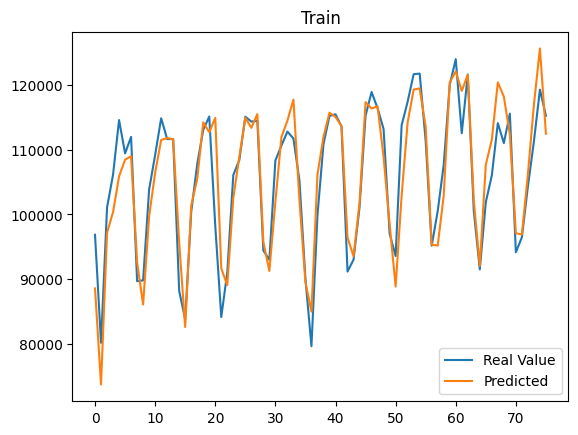

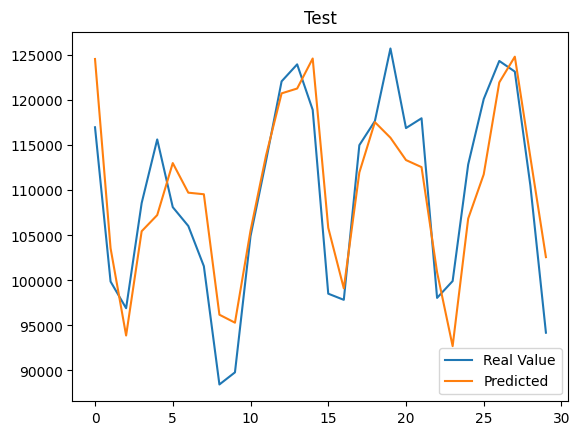

In [248]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [249]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [250]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape = np.mean(numerator / denominator)
    return smape * 100

In [251]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)
    evaluate(smape, 'smape', train_df['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)
    evaluate(smape, 'smape', test_df['Demand'], test_prediction_df)


In [252]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 43.4590387660243
MSE : 20078.25535951846
MAPE : 2031589939827035.8
smape : 32.79180009255548
XGB test scores:
MAE : 51.059956831017715
MSE : 29907.59793611639
MAPE : 1942285702530558.5
smape : 31.874498410728936


### Feature Importance and SHAPE

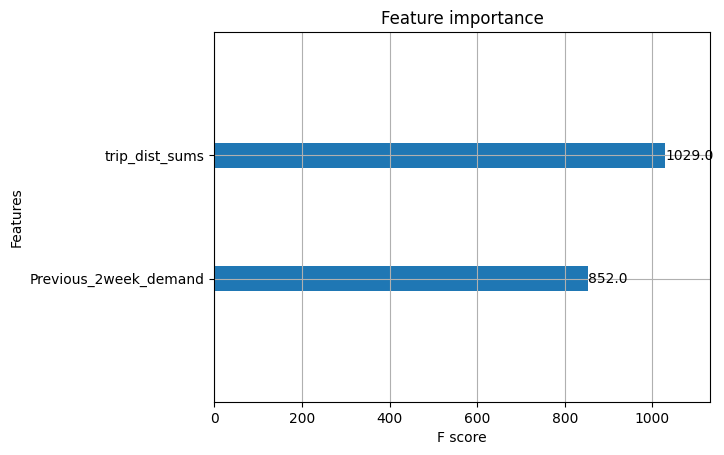

In [253]:
xgb.plot_importance(model)
plt.show()

In [254]:
'''dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])'''

"dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)\n\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(dtrain_reg)\nshap.summary_plot(shap_values, train_df[FEATURE_LIST])"

# File Saving

In [255]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [256]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [257]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [258]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,2.974358
1,1,2023-04-02,-2.579402
2,1,2023-04-03,3.603253
3,1,2023-04-04,2.876985
4,1,2023-04-05,3.603253


In [259]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)